In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
from pyarrow import parquet 
import numpy as np
import sys 
sys.path.append('/home/bekah/gPhoton2')
from gPhoton.pipeline import execute_pipeline
from astropy.io import fits
import os 
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [4]:
def get_selected_sources(eclipse, folder):
    """ get central sources from both fuv and nuv for the same eclipse. returns concat
    pd df with sources from both bands. """
    
    nuv_list_name = f"e{eclipse}-nd-full-0-photom-12_8.csv"
    fuv_list_name = f"e{eclipse}-fd-full-0-photom-12_8.csv"
    nuv_image_name = f"e{eclipse}-nd-full-0-rice.fits"
    fuv_image_name = f"e{eclipse}-fd-full-0-rice.fits"

    nuvexists, nuvpath = check_file_in_folder(folder, nuv_list_name) 
    fuvexists, fuvpath = check_file_in_folder(folder, fuv_list_name) 

    if nuvexists & fuvexists: 
        nuv = pd.read_csv(nuvpath)  
        nuv['band'] = 'nuv'
        fuv = pd.read_csv(fuvpath) 
        fuv['band'] = 'fuv'
        
        fuvandnuv = pd.concat([nuv, fuv])

        return fuvandnuv 

def check_file_in_folder(folder_path, file_name):
    try:
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):
            return True, file_path
        else:
            return False
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
    except PermissionError:
        print(f"Permission error accessing folder '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
        
def dbscan_group(fuvandnuv): 
    fuvandnuv_xy = list(zip(fuvandnuv['ra'],fuvandnuv['dec']))
    dbscan = DBSCAN(eps=.001, min_samples=2)
    labels = dbscan.fit_predict(fuvandnuv_xy)
    points_with_labels = zip(fuvandnuv_xy, labels)
    
    labelsdf = pd.DataFrame(points_with_labels, columns=['Point', 'Label'])
    labelsdf[['X', 'Y']] = labelsdf['Point'].apply(lambda x: pd.Series({'X': x[0], 'Y': x[1]}))
    labelsdf = labelsdf.drop('Point', axis=1)
    return labelsdf 


def calculate_vector(group):
    group['dx'] = group['ra'].diff()
    group['dy'] = group['dec'].diff()
    group['size_diff'] = group['equivalent_radius'].diff()
    return group 

def filter_middle_50_percent(group):
    lower_bound_r = group['ra'].quantile(0.25)
    upper_bound_r = group['ra'].quantile(0.75)
    lower_bound_d = group['dec'].quantile(0.25)
    upper_bound_d = group['dec'].quantile(0.75)
    filtered = group[(group['ra'] >= lower_bound_r) & (group['ra'] <= upper_bound_r)
                    & (group['dec'] >= lower_bound_d) & (group['dec'] <= upper_bound_d)]

    return filtered

In [2]:
def compare_bands(eclipse, eclipse_folder_path):
    
    e23330 = get_selected_sources(eclipse, eclipse_folder_path)

    color_mapping = {'nuv': 'red', 'fuv': 'blue'}

    e23330['Color'] = e23330['band'].map(color_mapping)

    # filter to middle of eclipse, change this 
    #selected_e23330 = e23330[(e23330['dec'] > -13.4) & (e23330['dec'] < -13.2) &
    #                           (e23330['ra'] > 354.2) & (e23330['ra'] < 354.4)]
    
    # Apply the function to each column
    
    #selected_e23330 = e23330.apply(filter_middle_30_percent)

    selected_e23330 = filter_middle_50_percent(e23330)

    label_e23330 = dbscan_group(selected_e23330)
    
    e23330_matches = label_e23330[(label_e23330['Label'] > 1)]
    
    label_e23330 = label_e23330.rename(columns={"X": "ra", "Y": "dec"})

    merged = pd.merge(selected_e23330, label_e23330, on=['ra', 'dec'], how='inner', validate="one_to_one")
    
    merged = merged[(merged['Label'] > 1)]
    
    label_groups = merged.sort_values(['band']).groupby('Label')
    
    # Apply the function to each group
    result_df = label_groups.apply(calculate_vector)
    
    result_df['vector_length'] = np.sqrt(result_df['dx']**2 + result_df['dy']**2)

    result_df = result_df.droplevel(1)
    
    vectors = result_df.dropna(axis=0)
    vectors = vectors[['dx', 'dy', 'vector_length', 'size_diff']].copy()

    labels_with_vectors = pd.merge(merged, vectors, on='Label')
        
    labels_with_vectors = labels_with_vectors[(labels_with_vectors['band'] == 'fuv')]
        
    return labels_with_vectors 

In [ ]:
eclipse_list = [23054,
 23062,
 23068,
 23085,
 23154,
 23258,
 23328,
 23330,
 23331,
 23334,
 23335,
 23336,
 23340]

In [5]:
eclipse = 1734
metadata = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/metadata.parquet',
                                  filters=[('eclipse','==',eclipse),
                                          ]).to_pandas()
metadata 

,eclipse,obstype,legs,ra_max,ra_min,dec_max,dec_min,fuv_temp
0,1734,MIS,0,348.057153,348.033923,0.600648,0.576333,29.524041


In [47]:
low_eclipse = 0
high_eclipse = 23342
metadata = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/metadata.parquet',
                                  filters=[('eclipse','>',low_eclipse),('eclipse','<',high_eclipse),
                                           ('fuv_temp','>',0), ('obstype','==','MIS'),
                                          ('legs','==',0)]).to_pandas()

metadata

,eclipse,obstype,legs,ra_max,ra_min,dec_max,dec_min,fuv_temp
0,584,MIS,0,231.935382,231.909720,3.354200,3.328683,29.760754
1,585,MIS,0,231.308018,231.281993,2.492200,2.465765,29.884028
2,586,MIS,0,230.843428,230.817620,3.249198,3.223566,29.738932
3,589,MIS,0,232.986327,232.960699,3.532465,3.506340,29.292674
4,922,MIS,0,236.511259,236.489025,1.550949,1.528694,27.771788
...,...,...,...,...,...,...,...,...
1839,23334,MIS,0,355.919781,355.893344,-12.506788,-12.531735,28.511340
1840,23335,MIS,0,356.422332,356.396890,-13.377620,-13.403029,28.935746
1841,23336,MIS,0,352.385924,352.360894,-4.638742,-4.664060,30.090052
1842,23340,MIS,0,353.425808,353.400663,-6.394999,-6.420002,27.732020


In [ ]:
plt.scatter(metadata['eclipse'],metadata['fuv_temp'])

In [ ]:
import os
import re

def extract_numbers(folder_name):
    # Use regular expression to extract numbers
    match = re.search(r'\d+', folder_name)
    if match:
        return int(match.group())
    else:
        return None

def get_numbers_from_folders(directory_path):
    # Get a list of all directories in the specified path
    directories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

    # Extract numbers from folder names
    numbers = [extract_numbers(folder) for folder in directories]

    # Filter out None values (folders without numbers)
    numbers = [num for num in numbers if num is not None]

    return numbers

# Specify the directory path
directory_path = "/media/bekah/BekahA/eclipses_no_correction"

# Get numbers from folders in the specified directory
result = get_numbers_from_folders(directory_path)

# Print the result
print(result)

In [46]:
correction = []
nocorrection = []

eclipse_list = [922, 1910, 2117, 2188, 2313, 2344, 2372, 2461, 2477, 2492, 2506, 2564, 2618, 23054, 23062, 23068, 23085, 23154, 23258, 23328, 23330, 23331, 23334, 23335, 23336, 23340]

for eclipse in eclipse_list: 
    print(eclipse)
    eclipsename = str(eclipse).zfill(5)
    eclipse_folder_path = "/media/bekah/BekahA/eclipses/e"+str(eclipsename)+"/"
    eclipse_folder_path_no_corection = "/media/bekah/BekahA/eclipses_no_correction/e"+str(eclipsename)+"/"
    labels_with_vectors = compare_bands(eclipsename, eclipse_folder_path)
    labels_without_correction = compare_bands(eclipsename, eclipse_folder_path_no_corection)
    labels_with_vectors['eclipse']=eclipse
    labels_without_correction['eclipse']=eclipse
    small = labels_with_vectors[(labels_with_vectors['size_diff'] <= .5)]
    small_nocorrect = labels_without_correction[(labels_without_correction['size_diff'] <= .5)]
    correction.append(small)
    nocorrection.append(small_nocorrect)
    
cor_df = pd.concat(correction, ignore_index=True)
no_cor_df = pd.concat(nocorrection, ignore_index=True)



922
1910
2117
2188
2313
2344
2372
2461
2477
2492
2506
2564
2618
23054
23062
23068
23085
23154
23258
23328
23330
23331
23334
23335
23336
23340


In [48]:
cor_df = cor_df.merge(metadata, on='eclipse')
cor_df

,xcentroid,ycentroid,area,segment_flux,elongation,eccentricity,equivalent_radius,orientation,max_value,maxval_xindex,...,vector_length,size_diff,eclipse,obstype,legs,ra_max,ra_min,dec_max,dec_min,fuv_temp
0,2238.985296,646.376842,29.0,0.061465,1.159597,0.506281,3.038254,-59.802357,0.005534,2240,...,0.000035,-1.545549,922,MIS,0,236.511259,236.489025,1.550949,1.528694,27.771788
1,1970.011132,688.499493,6.0,0.017869,1.618449,0.786276,1.381977,1.099319,0.005329,1970,...,0.000623,0.213793,922,MIS,0,236.511259,236.489025,1.550949,1.528694,27.771788
2,1824.248404,729.499973,12.0,0.032305,1.288090,0.630310,1.954410,59.976153,0.008449,1825,...,0.000280,-0.826031,922,MIS,0,236.511259,236.489025,1.550949,1.528694,27.771788
3,2080.420366,823.418155,13.0,0.044593,1.141503,0.482243,2.034214,32.639871,0.008421,2080,...,0.000390,0.076790,922,MIS,0,236.511259,236.489025,1.550949,1.528694,27.771788
4,1796.659543,835.874048,45.0,0.143233,2.047032,0.872557,3.784699,0.577074,0.007162,1799,...,0.000338,-0.446908,922,MIS,0,236.511259,236.489025,1.550949,1.528694,27.771788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,1264.336517,2072.892593,14.0,0.016298,1.401342,0.700551,2.111004,31.530700,0.002158,1265,...,0.000336,-0.618299,23340,MIS,0,353.425808,353.400663,-6.394999,-6.420002,27.732020
3218,1532.890080,2089.864475,20.0,0.037858,1.392301,0.695800,2.523133,-50.558982,0.004421,1532,...,0.000353,0.297815,23340,MIS,0,353.425808,353.400663,-6.394999,-6.420002,27.732020
3219,2081.188768,2089.980221,24.0,0.033886,1.529791,0.756767,2.763953,0.914811,0.004838,2081,...,0.000256,0.167662,23340,MIS,0,353.425808,353.400663,-6.394999,-6.420002,27.732020
3220,1205.192378,2093.108494,27.0,0.045502,1.479248,0.736884,2.931615,56.630750,0.004855,1204,...,0.000225,0.106639,23340,MIS,0,353.425808,353.400663,-6.394999,-6.420002,27.732020


In [49]:
no_cor_df = no_cor_df.merge(metadata, on='eclipse')
no_cor_df

,xcentroid,ycentroid,area,segment_flux,elongation,eccentricity,equivalent_radius,orientation,max_value,maxval_xindex,...,vector_length,size_diff,eclipse,obstype,legs,ra_max,ra_min,dec_max,dec_min,fuv_temp
0,2243.916708,900.575121,10.0,0.032259,1.324138,0.655485,1.784124,38.783785,0.006297,2244,...,0.000304,0.326880,922,MIS,0,236.511259,236.489025,1.550949,1.528694,27.771788
1,2417.829339,1064.623661,5.0,0.015888,1.722913,0.814323,1.261566,17.827937,0.008471,2418,...,0.000378,-0.133187,922,MIS,0,236.511259,236.489025,1.550949,1.528694,27.771788
2,2552.053813,1068.099564,42.0,0.119107,1.485338,0.739417,3.656366,79.974397,0.009363,2551,...,0.000419,-0.892413,922,MIS,0,236.511259,236.489025,1.550949,1.528694,27.771788
3,2789.309645,1141.184998,34.0,0.033755,2.294195,0.900003,3.289762,-19.735907,0.003055,2792,...,0.000930,0.142069,922,MIS,0,236.511259,236.489025,1.550949,1.528694,27.771788
4,2745.071190,1170.267027,57.0,0.065809,2.107997,0.880318,4.259538,-17.817624,0.003092,2750,...,0.000564,-0.691290,922,MIS,0,236.511259,236.489025,1.550949,1.528694,27.771788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180,1532.889756,2089.864881,20.0,0.038015,1.394789,0.697120,2.523133,-50.645775,0.004421,1532,...,0.000482,0.297815,23340,MIS,0,353.425808,353.400663,-6.394999,-6.420002,27.732020
3181,2081.188929,2089.981288,24.0,0.033884,1.530451,0.757011,2.763953,0.892055,0.004791,2081,...,0.000325,0.167662,23340,MIS,0,353.425808,353.400663,-6.394999,-6.420002,27.732020
3182,1205.194191,2093.109987,27.0,0.045518,1.481205,0.737702,2.931615,56.589278,0.004854,1204,...,0.000374,0.106639,23340,MIS,0,353.425808,353.400663,-6.394999,-6.420002,27.732020
3183,2248.808085,2098.221089,6.0,0.009202,1.348165,0.670677,1.381977,-45.198370,0.003287,2248,...,0.000478,-0.253597,23340,MIS,0,353.425808,353.400663,-6.394999,-6.420002,27.732020


In [50]:
small = labels_with_vectors[(labels_with_vectors['size_diff'] <= .5)]
small_nocorrect = labels_without_correction[(labels_without_correction['size_diff'] <= .5)]

In [ ]:
plt.hist(cor_df['dy'],label='correction')
plt.hist(no_cor_df['dy'], alpha=.5, label='no correction')
plt.legend()
plt.xlabel("dy offset in degrees")
plt.title('all sources')

In [55]:
small['dy'].describe()

count    159.000000
mean      -0.000128
std        0.000261
min       -0.001457
25%       -0.000240
50%       -0.000089
75%        0.000020
max        0.000509
Name: dy, dtype: float64

In [56]:
small_nocorrect['dy'].describe()

count    158.000000
mean       0.000015
std        0.000223
min       -0.000747
25%       -0.000111
50%        0.000035
75%        0.000145
max        0.000642
Name: dy, dtype: float64

In [57]:
small['dx'].describe()

count    159.000000
mean       0.000124
std        0.000225
min       -0.000558
25%       -0.000017
50%        0.000103
75%        0.000267
max        0.000705
Name: dx, dtype: float64

In [58]:
small_nocorrect['dx'].describe()

count    158.000000
mean       0.000233
std        0.000220
min       -0.000445
25%        0.000095
50%        0.000220
75%        0.000379
max        0.000824
Name: dx, dtype: float64

In [59]:
corrected_dx = cor_df.groupby('eclipse')['dx'].describe()
uncorrected_dx = no_cor_df.groupby('eclipse')['dx'].describe()
corrected_dy = cor_df.groupby('eclipse')['dx'].describe()
cor_fuv = cor_df.groupby('eclipse')['fuv_temp'].describe()
uncorrected_dy = no_cor_df.groupby('eclipse')['dy'].describe()
uncor_fuv = no_cor_df.groupby('eclipse')['fuv_temp'].describe()

In [ ]:
cor_groups = cor_df.groupby('eclipse')
no_cor_groups = no_cor_df.groupby('eclipse')

In [ ]:
corrected_dy

In [ ]:
plt.scatter(corrected_dy.index,corrected_dy['25%'], label='corrected 25')
plt.scatter(uncorrected_dy.index,uncorrected_dy['25%'], label='uncorrected 25')
plt.scatter(corrected_dy.index,corrected_dy['75%'], label='corrected 75')
plt.scatter(uncorrected_dy.index,uncorrected_dy['75%'], label='uncorrected 75')
plt.legend()
plt.xlabel('eclipse')
plt.ylabel(' y offset in degrees')

In [ ]:
plt.grid()
plt.scatter(cor_fuv['mean'],corrected_dy['mean'],label='corrected')
plt.scatter(uncor_fuv['mean'],uncorrected_dy['mean'], label='uncorrected')
plt.legend()
plt.xlabel('fuv_temp')
plt.ylabel('mean y offset in degrees')
plt.title('close in size sources only')

In [ ]:
plt.grid()
plt.scatter(cor_fuv['mean'],corrected_dy['50%'],label='corrected')
plt.scatter(uncor_fuv['mean'],uncorrected_dy['50%'], label='uncorrected')
plt.legend()
plt.xlabel('fuv_temp')
plt.ylabel('mean y offset in degrees')


(array([1., 0., 0., 0., 4., 0., 5., 2., 8., 6.]),
 array([-3.16883149e-04, -2.61947358e-04, -2.07011567e-04, -1.52075776e-04,
        -9.71399846e-05, -4.22041936e-05,  1.27315975e-05,  6.76673885e-05,
         1.22603180e-04,  1.77538971e-04,  2.32474762e-04]),
 <BarContainer object of 10 artists>)

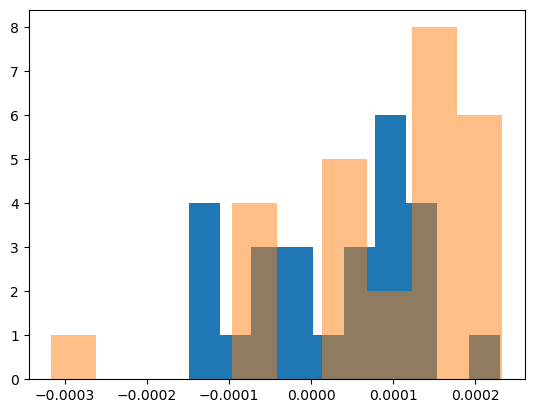

In [60]:
plt.hist(corrected_dy['mean'])
plt.hist(uncorrected_dy['mean'], alpha=0.5)

In [ ]:
plt.hist(cor_df['dx'], label='correction')
plt.hist(no_cor_df['dx'], label='no correction', alpha=.5)
plt.legend()
plt.xlabel('dx offset in degrees')
plt.title('all sources')

In [ ]:
# Plotting
plt.scatter(small['ra'], 
            small['dec'], 
            c=small["Color"],
            s=small['equivalent_radius'],
            alpha=.6)

# Plot vectors
#for index, row in labels_with_vectors.iterrows():
#    plt.arrow(row['ra'], row['dec'], 0, row['dy'], head_width=0.0001, head_length=0.00001, fc='red', ec='red')

plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

In [ ]:
# Plotting
plt.scatter(small_nocorrect['ra'], 
            small_nocorrect['dec'], 
            c=small_nocorrect["Color"],
            s=small_nocorrect['equivalent_radius'],
            alpha=.6)

# Plot vectors
#for index, row in labels_with_vectors.iterrows():
#    plt.arrow(row['ra'], row['dec'], 0, row['dy'], head_width=0.0001, head_length=0.00001, fc='red', ec='red')

plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

In [ ]:
# Plot vectors
for index, row in labels_without_correction.iterrows():
    plt.arrow(row['ra'], row['dec'], 0, row['dy'], head_width=0.01, head_length=0.01, fc='red', ec='red')

In [ ]:
plt.hist(labels_with_vectors['vector_length'])
plt.hist(labels_without_correction['vector_length'])

In [ ]:
plt.hist(labels_with_vectors['dx'])
plt.hist(labels_without_correction['dx'])

In [ ]:
labels_with_vectors['dy'].describe()

In [ ]:
labels_without_correction['dy'].describe()

In [ ]:
plt.scatter(labels_without_correction['equivalent_radius'], labels_without_correction['dx'])

In [ ]:
plt.scatter(labels_with_vectors['equivalent_radius'], labels_with_vectors['dy'])

In [ ]:
plt.hist(old["dy"])
plt.hist(new["dy"], alpha=.5)


In [39]:
eclipse = 2506

eclipsename = str(eclipse).zfill(5)

eclipse_folder_path_new = "/media/bekah/BekahA/eclipses/e"+eclipsename+"/"
eclipse_folder_path_old = "/media/bekah/BekahA/eclipses/e"+eclipsename+"_oldcorrection/"

new = compare_bands(eclipsename, eclipse_folder_path_new)
old = compare_bands(eclipsename, eclipse_folder_path_old)

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

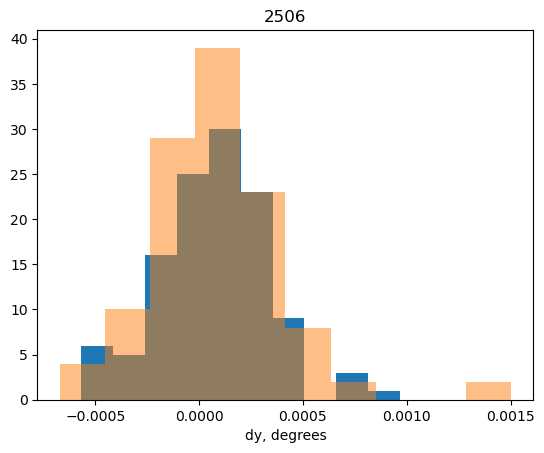

In [40]:
plt.hist(new['dy'], label="new")
plt.hist(old['dy'],alpha=.5, label="old")
plt.title(f"{eclipse}")
plt.xlabel("dy, degrees")
plt.legend

In [41]:
small_new = new[(new['size_diff'] <= .5)]
small_old = old[(old['size_diff'] <= .5)]

In [42]:
small_new['dy'].describe()

count    48.000000
mean      0.000059
std       0.000270
min      -0.000570
25%      -0.000111
50%       0.000060
75%       0.000182
max       0.000800
Name: dy, dtype: float64

In [43]:
small_old['dy'].describe()

count    48.000000
mean      0.000141
std       0.000402
min      -0.000571
25%      -0.000086
50%       0.000079
75%       0.000282
max       0.001502
Name: dy, dtype: float64

In [44]:
small_new['dx'].describe()

count    48.000000
mean     -0.000015
std       0.000318
min      -0.000795
25%      -0.000186
50%      -0.000080
75%       0.000243
max       0.000730
Name: dx, dtype: float64

In [45]:
small_old['dx'].describe()

count    48.000000
mean     -0.000008
std       0.000333
min      -0.000695
25%      -0.000194
50%      -0.000056
75%       0.000191
max       0.000722
Name: dx, dtype: float64

In [ ]:
small_new['vector_length'].describe()

In [ ]:
small_old['vector_length'].describe()

In [ ]:
small_old['size_diff'].describe()

In [ ]:
small_new['size_diff'].describe()['mean']-small_old['size_diff'].describe()['mean']

In [ ]:
(0.015823256797442578/1.5)*100

In [ ]:
1.5 arcsec/pixe 